## Predicting house prices: a regression example

The two previous examples were considered classification problems, where the goal
was to predict a single discrete label of an input data point. Another common type of
machine-learning problem is regression, which consists of predicting a continuous
value instead of a discrete label:

## The Boston Housing Price dataset

You’ll attempt to predict the median price of homes in a given Boston suburb in the
mid-1970s, given data points about the suburb at the time, such as the crime rate, the
local property tax rate, and so on. The dataset you’ll use has an interesting difference
from the two previous examples. It has relatively few data points: only 506, split
between 404 training samples and 102 test samples. And each feature in the input data
(for example, the crime rate) has a different scale. For instance, some values are pro-
portions, which take values between 0 and 1; others take values between 1 and 12, oth-
ers between 0 and 100, and so on.

## Loading the Boston housing dataset

In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 2us/step


## Preparing the data

It would be problematic to feed into a neural network values that all take wildly differ-
ent ranges. The network might be able to automatically adapt to such heterogeneous
data, but it would definitely make learning more difficult. A widespread best practice
to deal with such data is to do feature-wise normalization: for each feature in the input
data (a column in the input data matrix), you subtract the mean of the feature and
divide by the standard deviation, so that the feature is centered around 0 and has a
unit standard deviation. This is easily done in Numpy.

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

## Building your network

Because so few samples are available, you’ll use a very small network with two hidden
layers, each with 64 units. In general, the less training data you have, the worse overfit-
ting will be, and using a small network is one way to mitigate overfitting.

In [7]:
#Model definition
from keras import models
from keras import layers
#Because you’ll need to instantiate
#the same model multiple times, you
#use a function to construct it.
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
    input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

The network ends with a single unit and no activation (it will be a linear layer). This is
a typical setup for scalar regression (a regression where you’re trying to predict a single
continuous value). Applying an activation function would constrain the range the out-
put can take; for instance, if you applied a sigmoid activation function to the last layer,
the network could only learn to predict values between 0 and 1. Here, because the last
layer is purely linear, the network is free to learn to predict values in any range.

## Validating your approach using K-fold validation
To evaluate your network while you keep adjusting its parameters (such as the number
of epochs used for training), you could split the data into a training set and a valida-
tion set, as you did in the previous examples. But because you have so few data points,
the validation set would end up being very small (for instance, about 100 examples).
As a consequence, the validation scores might change a lot depending on which data
points you chose to use for validation and which you chose for training: the validation
scores might have a high variance with regard to the validation split. This would pre-
vent you from reliably evaluating your model.
The best practice in such situations is to use K -fold cross-validation (see figure 3.11).
It consists of splitting the available data into K partitions (typically K = 4 or 5), instanti-
ating K identical models, and training each one on K – 1 partitions while evaluating on
the remaining partition. The validation score for the model used is then the average of
the K validation scores obtained. In terms of code, this is straightforward.

In [10]:
#K-fold validation
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
#Builds the Keras model (already compiled)
#Trains the model )in silent mode,verbose = 0)
model = build_model()
model.fit(partial_train_data, partial_train_targets,
epochs=num_epochs, batch_size=1, verbose=0)
val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
all_scores.append(val_mae)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [13]:
#Saving the validation logs at each fold
num_epochs = 500
#Prepares the validation data: #data from partition #k
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)

#Prepares the training data: data from all other partitions
partial_train_targets = np.concatenate(
[train_targets[:i * num_val_samples],
train_targets[(i + 1) * num_val_samples:]],
axis=0)
#Builds the Keras model(already compiled)
model = build_model()
history = model.fit(partial_train_data, partial_train_targets,
validation_data=(val_data, val_targets),
epochs=num_epochs, batch_size=1, verbose=0)
mae_history = history.history['val_mean_absolute_error']
all_mae_histories.append(mae_history)
#Trains the model(in silent mode, verbose=0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


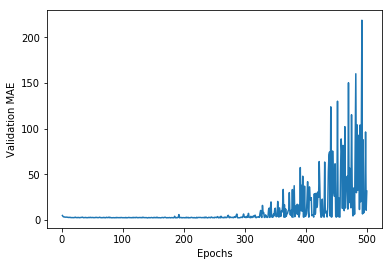

In [15]:
#You can then compute the average of the per-epoch MAE scores for all folds.
#Building the history of successive mean K-fold validation scores
average_mae_history = [
np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
#Let’s plot this; 
#Listing 3.30 Plotting validation scores
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

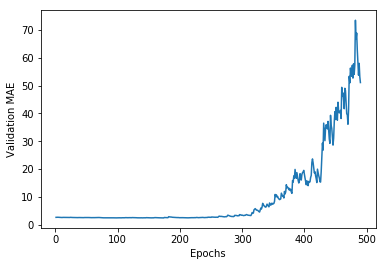

In [16]:
#Plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [17]:
#Training the final model
#Gets a fresh, compiled model
model = build_model()
#Trains it on the entirety of the data
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 537us/step


In [19]:
test_mae_score

2.9992925700019386

Here’s what you should take away from this example:
* Regression is done using different loss functions than what we used for classification. Mean squared error ( MSE ) is a loss function commonly used for regres-
sion.
* Similarly, evaluation metrics to be used for regression differ from those used for
classification; naturally, the concept of accuracy doesn’t apply for regression. A
common regression metric is mean absolute error ( MAE ).
* When features in the input data have values in different ranges, each feature
should be scaled independently as a preprocessing step.
* When there is little data available, using K-fold validation is a great way to reli-
ably evaluate a model.
* When little training data is available, it’s preferable to use a small network with
few hidden layers (typically only one or two), in order to avoid severe overfitting.